### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	
- 1. 시계열의 안정성이 충분히 확인되었는가?
    - 플로팅과 adfuller 메소드가 모두 적절히 사용되었음

- 2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
    - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨

- 3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
    - 3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨

### 노트요약

#### 시계열 데이터를 통해 미래를 예측하려면 필요한 전제
- 과거의 데이터에 일정한 패턴이 발견된다
- 과거의 패턴은 미래에도 동일하게 반복될 것이다
- 즉, 안정적인 데이터에 대해서만 미래 예측이 가능하다는 의미로 해석된다
- 이는 시간의 변화와는 무관하게 일정한 프로세스가 존재한다는것으로도 볼 수 있다.
    - 기후변화와 같이 시간의 흐름에 따라 어느정도 반복적인 패턴을 보인다면, 과거와 현재를 비교하여 앞으로 예상되는 기후변화를 예측 할 수 있을것이다.

#### 시계열 데이터 분석은 완벽한 미래 예측을 보장하지 못한다
- 그럼에도 불구하고 미래를 예측해야 한다면,
- 데이터의 안정성을 훼손하는 외부 데이터(특성)을 어떠한 기준으로 선정해야 하는지가 중요하게 작용 할 것이다.
- 또한 의도적으로 불안정한 데이터를 안정화 하는 작업도 필요할 것이다.

#### 타겟 설정과 시계열 데이터의 안정화
- 타겟은 최근 한달간의 종가로 선정하였다.
- 시계열 데이터의 안정화를 하기위해 ARIMA(자기회귀누적이동평균)모형을 선택하여 적용해보고자 한다. 
- 이를 베이스라인 모델로 선형회귀 모델과 비교해보고, 각 모델의 정확도accuracy를 통해 평가지표로 선정함

#### 안정적인 시계열 데이터의 특징
- 아래 링크를 참고하여 안정적인 시계열 데이터가 갖추어야 할 조건을 살펴보았다
http://www.dodomira.com/2016/04/21/arima_in_r/

- 시간의 추이와 관계 없이 평균이 불변할때
- 시간의 추이와 관계 없이 분산이 불변할때
- 두 시점 간의 공분산 ( 자기 공분산 - autocovariance ) 이 기준시점과 무관할때
- 위 조건을 충족하면 안정적인 시계열 데이터라고 할 수 있다.


#### 간단 요약
- 통계적으로 어려운 용어와 개념이 등장하여 간단히 요약하여 이해해보면
- 어느 한때, 즉 시각을 t 라고 했을때 x(t-1), x(t-2), X(t-3), x(t-4) 와 같은 과거의 변화를 가지고 x(t+1)의 값을 예측한다고 했을때
- 해당 예측이 유의미하려면 t에 무관하게 예측이 맞아야 한다는 것이다.
- 시간에 따른 변화량을 h라고 했을때 x(t-h)와 x(t)는 t와 무관하게 h에 대해서만 달라지는 일정한 상관도를 지녀야 한다
- 위 기준이 충족되지 않는다면 과거에서 발견한 패턴이 미래에도 반복될 것이라는 시계열 예측의 전제가 무의미하다고 볼 수 있다.


### STEP 1 : 시계열 데이터 준비


In [2]:
!pip install statsmodels

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/BTC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

In [4]:
ts.shape

(2352,)

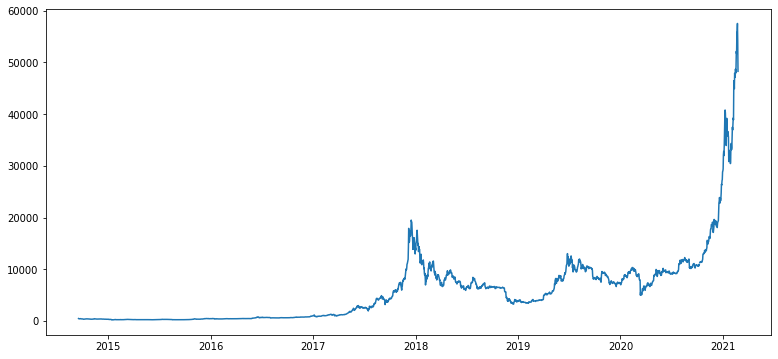

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts);

Series([], Name: Close, dtype: float64)


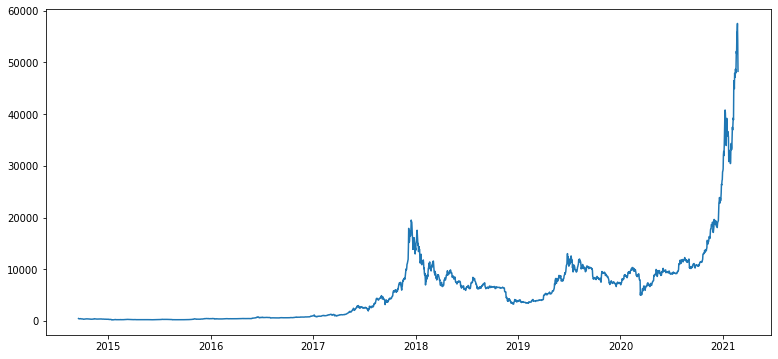

In [6]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts);

일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수입니다. 현재 타임스텝부터 window에 주어진 타임스텝 이전 사이 구간의 평균(rolling mean, 이동평균)과 표준편차(rolling std, 이동표준편차)를 원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있을 것입니다.

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

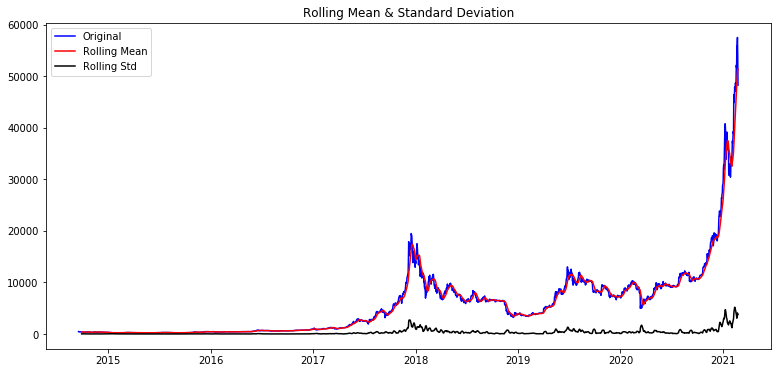

In [8]:
plot_rolling_statistics(ts, window=12)

### 함수선언 및 라이브러리 불러오기


In [9]:
! pip install statsmodels

#### statsmodels 패키지를 사용하였다.
- R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지로,
- statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드를 활용하였다.


In [10]:
from statsmodels.tsa.stattools import adfuller

def plot_rolling_statistics(timeseries, window=12): # 윈도우의 크기는 12개월 6개월등으로 조절할 수 있다.
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### STEP 2 : 각종 전처리 수행

In [11]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력
# 결측치 없음

Series([], Name: Close, dtype: float64)

In [12]:
ts.head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

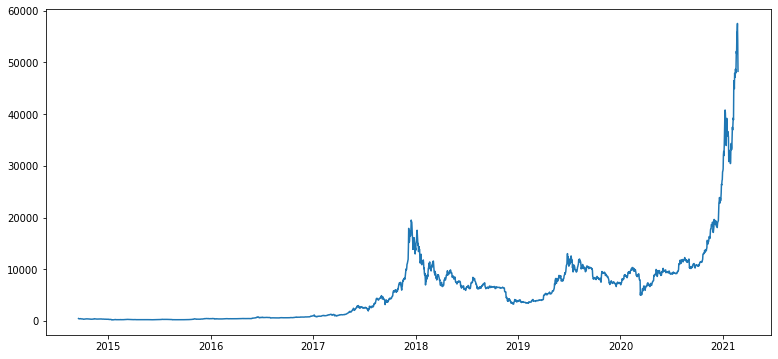

In [13]:
plt.plot(ts);

#### 시간 추이에 따라 분산이 점점 커지므로 이를 로그함수로 변환하여 안정화 하기

In [14]:
# 로그 변환을 통한 시계열 가공 
ts_log = np.log(ts)
ts_log.head()

Date
2014-09-17    6.125414
2014-09-18    6.050771
2014-09-19    5.978369
2014-09-20    6.013480
2014-09-21    5.988513
Name: Close, dtype: float64

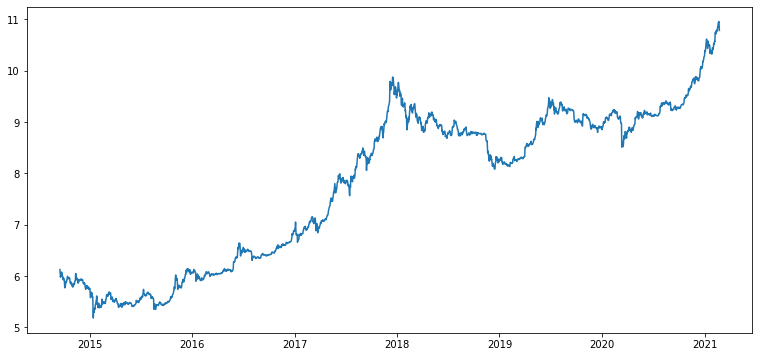

In [15]:
plt.plot(ts_log);

In [16]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                    0.269732
p-value                           0.975912
#Lags Used                       10.000000
Number of Observations Used    2341.000000
Critical Value (1%)              -3.433146
Critical Value (5%)              -2.862775
Critical Value (10%)             -2.567428
dtype: float64


### 가설설정

#### Augmented Dickey-Fuller Test(ADF Test)
- 시계열 데이터의 안정성을 테스트하는 통계적 방법으로 ADF Test를 적용하였다.
- 이 테스트는 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후, 
- 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다고 한다.  

#### 가설 설정

- 귀무가설 : 비트코인의 시계열 데이터는 안정적이지 않다
- 대립가설 : 비트코인의 시계열 데이터는 안정적이다
- 유의수준은 0.05로 설정

### 안정적 시계열 데이터를 위해 Moving average 제거
#### 이동평균 rolling mean 을 구하고 제거하여 추세 trend 상쇄하기
- 추세 trend는 시간 추이에 따라 나타나는 평균값 변화를 뜻하며,
- 시간 추이에 따라 평균이 증가하는 부분을 상쇄하는것으로 시계열 데이터를 안정화 할 수 있다.

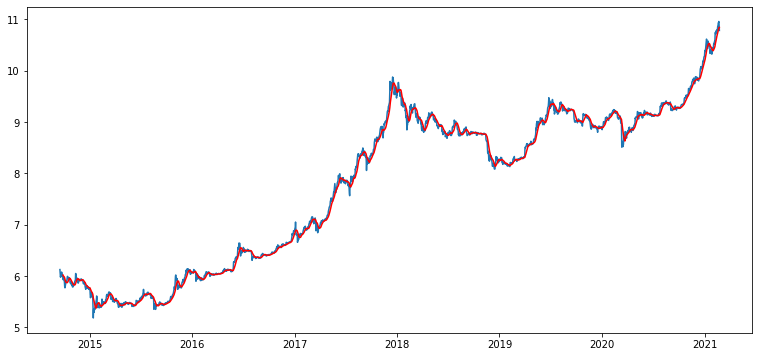

In [17]:
#Moving average 제거 - 추세(Trend) 상쇄하기
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [18]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2014-09-17         NaN
2014-09-18         NaN
2014-09-19         NaN
2014-09-20         NaN
2014-09-21         NaN
2014-09-22         NaN
2014-09-23         NaN
2014-09-24         NaN
2014-09-25         NaN
2014-09-26         NaN
2014-09-27         NaN
2014-09-28   -0.085928
2014-09-29   -0.074046
2014-09-30   -0.036229
2014-10-01   -0.042475
Name: Close, dtype: float64

In [19]:
## 이동 평균 계산시 발생한 결측치 제거
ts_log_moving_avg.dropna(inplace=True)#결측치 제거
ts_log_moving_avg.head(15)

Date
2014-09-28   -0.085928
2014-09-29   -0.074046
2014-09-30   -0.036229
2014-10-01   -0.042475
2014-10-02   -0.057800
2014-10-03   -0.091523
2014-10-04   -0.163855
2014-10-05   -0.163988
2014-10-06   -0.113859
2014-10-07   -0.078664
2014-10-08   -0.018686
2014-10-09    0.022509
2014-10-10    0.016499
2014-10-11    0.021510
2014-10-12    0.067214
Name: Close, dtype: float64

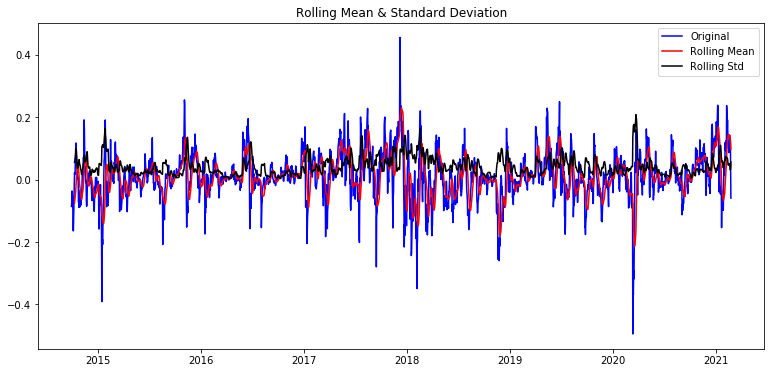

In [20]:
plot_rolling_statistics(ts_log_moving_avg)

In [21]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -9.819043e+00
p-value                        5.399532e-17
#Lags Used                     1.100000e+01
Number of Observations Used    2.329000e+03
Critical Value (1%)           -3.433161e+00
Critical Value (5%)           -2.862782e+00
Critical Value (10%)          -2.567431e+00
dtype: float64


### 안정적 시계열 데이터를 위해 차분 Differencing 하기
#### 계절성 Seasonality 상쇄하기
- 추세 trend에는 포착되지 않지만, 시계열 데이터 안에 포함된 주기적인 변화는 데이터의 불안정성 요소이다
- 이러한 계절적, 주기적 변화를 계절성 Seasonality라고 한다
- 이러한 패턴을 상쇄하기 위해 차분 Differencing 을 사용한다
    - 차분은 시계열을 한 스텝 앞으로 이동한 시계열을 원래 시계열에서 빼 주는 방법이다
    - 이를 통해 남는 값은 (현재 스텝 값 - 직접 스탭 값)으므로 이번 스텝에서 발생한 변화량을 나타낸다
    

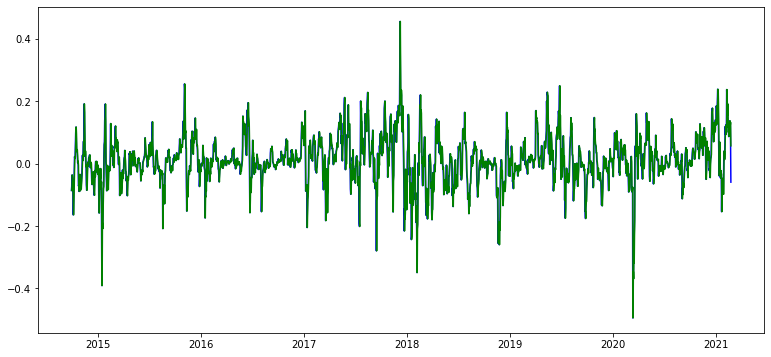

In [22]:
#차분을 위한 시프트 값 구하기
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

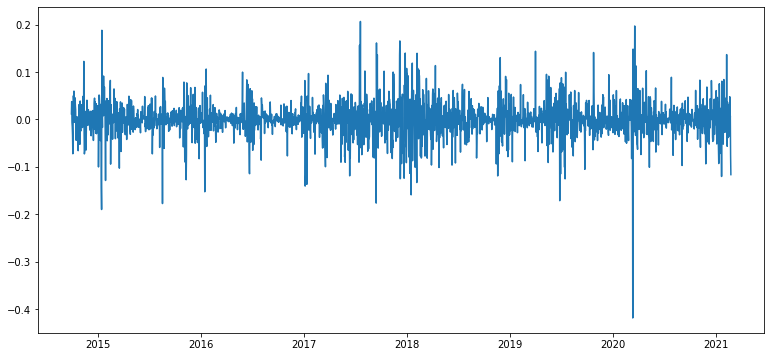

In [23]:
#1차 차분
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

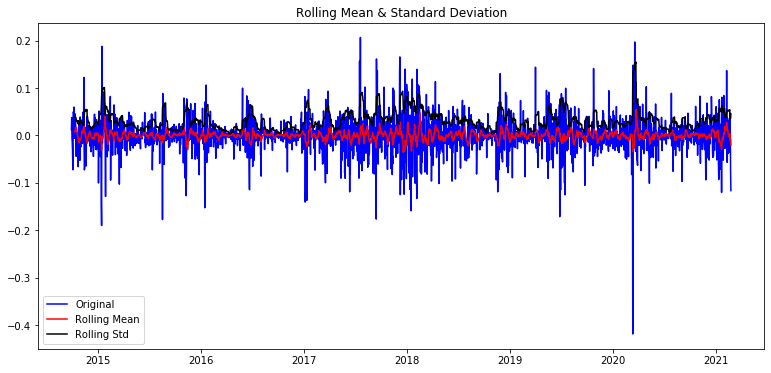

In [24]:
#1차 차분 시각화
plot_rolling_statistics(ts_log_moving_avg_diff)

In [25]:
#1차 차분 결과
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.429872e+01
p-value                        1.239591e-26
#Lags Used                     2.400000e+01
Number of Observations Used    2.315000e+03
Critical Value (1%)           -3.433178e+00
Critical Value (5%)           -2.862789e+00
Critical Value (10%)          -2.567435e+00
dtype: float64


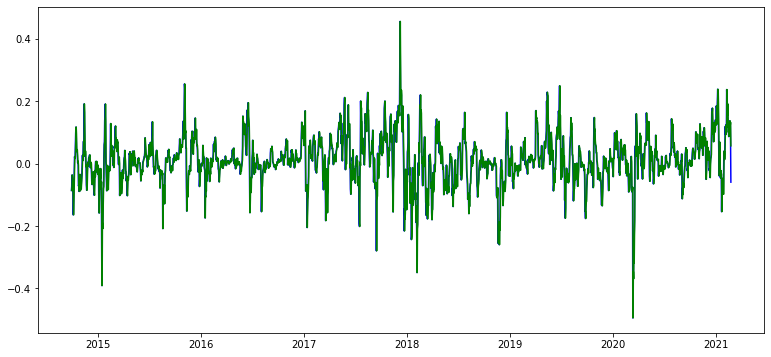

In [26]:
#2차 차분 시도
ts_log_moving_avg_diff_shift2 = ts_log_moving_avg_diff.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

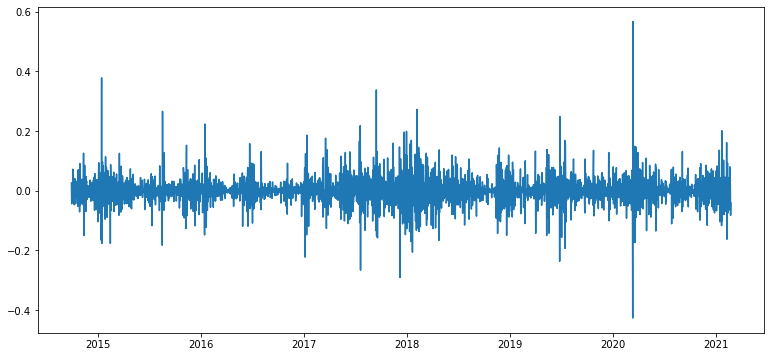

In [27]:
#2차 차분 
ts_log_moving_avg_diff2 = ts_log_moving_avg_diff - ts_log_moving_avg_diff_shift2
ts_log_moving_avg_diff2.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff2);

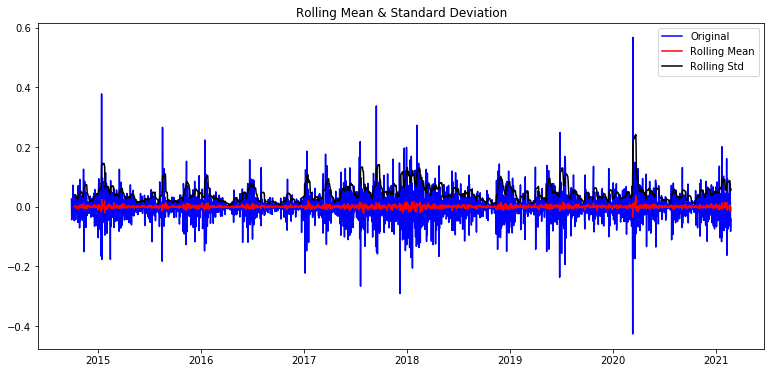

In [28]:
#2차 차분 시각화
plot_rolling_statistics(ts_log_moving_avg_diff2)

In [29]:
#2차 차분 결과
augmented_dickey_fuller_test(ts_log_moving_avg_diff2)

Results of Dickey-Fuller Test:
Test Statistic                -1.807191e+01
p-value                        2.602585e-30
#Lags Used                     2.600000e+01
Number of Observations Used    2.312000e+03
Critical Value (1%)           -3.433182e+00
Critical Value (5%)           -2.862791e+00
Critical Value (10%)          -2.567436e+00
dtype: float64


- Trend를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄하여도 여전히 높은 p-value (1.23)값을 보인다
- 2차 차분(2nd order differencing, 차분의 차분)을 적용하면 더욱 p-value를 낮출 수 있는지 확인해 보았다지만 오히려 늘어난 양상을 볼 수 있다.

#### 시계열 분해(Time series decomposition)
- statsmodels 라이브러리 안에는 seasonal_decompose 메소드를 활용하면
- 시계열 안에 존재하는 trend, seasonality를 직접 분리 할 수 있다.
- 위 기능을 활용하면 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리가 가능하다고 한다.


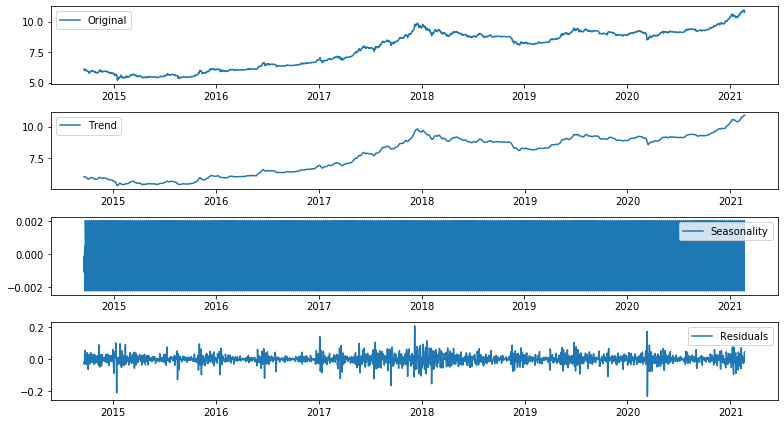

In [30]:
# seasonal_decompose 을 사용한 시계열 데이터 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세
seasonal = decomposition.seasonal #계절성
residual = decomposition.resid #잔차

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

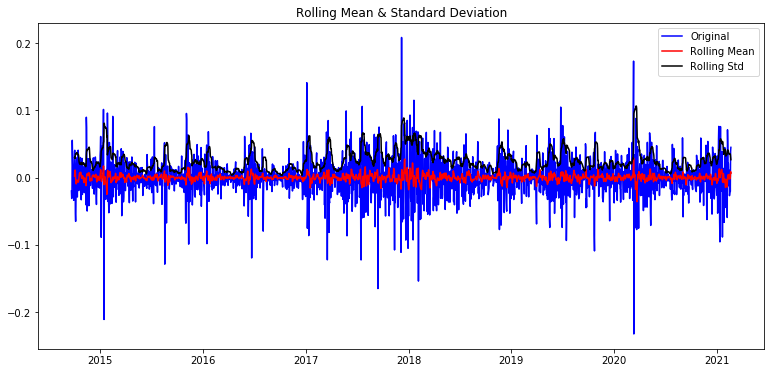

In [31]:
#seasonal_decompose를 활용한 잔차 구하기
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [32]:
#추세와 계절성을 분리한 시계열 데이터의  ADF test 
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.573675e+01
p-value                        1.270044e-28
#Lags Used                     2.300000e+01
Number of Observations Used    2.322000e+03
Critical Value (1%)           -3.433169e+00
Critical Value (5%)           -2.862786e+00
Critical Value (10%)          -2.567433e+00
dtype: float64


#### 종합하면 안정적인 시계열을 만들기 위해
- 시계열 데이터를 추세(Trend)와 계절성(Seasonality)와 잔차(Residual)로 분해하고,
- 여기서 추세(Trend)와 계절성(Seasonality)를 분리해 내면 어느정도 안정적인 시계열 데이터로 변환이 가능하다.

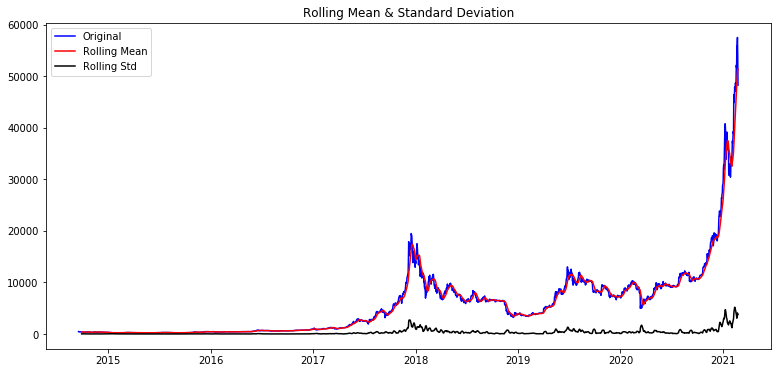

Results of Dickey-Fuller Test:
Test Statistic                    4.502029
p-value                           1.000000
#Lags Used                       27.000000
Number of Observations Used    2324.000000
Critical Value (1%)              -3.433167
Critical Value (5%)              -2.862784
Critical Value (10%)             -2.567432
dtype: float64


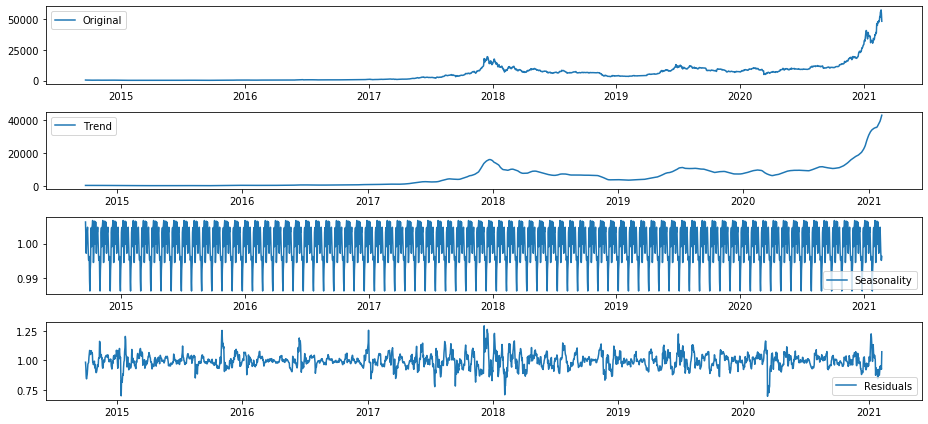

In [33]:
#로그 변환 전 데이터
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

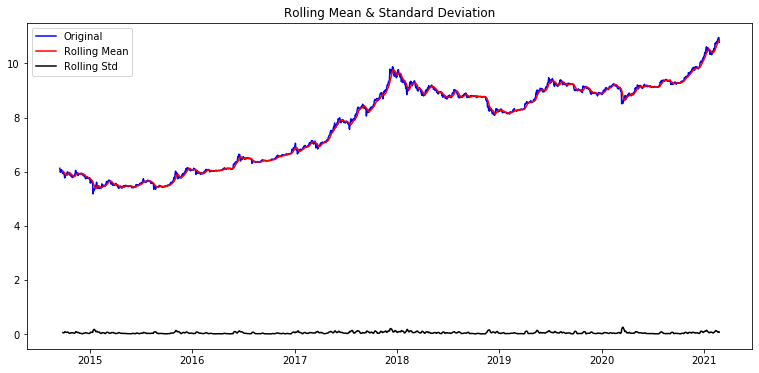

Results of Dickey-Fuller Test:
Test Statistic                    0.269732
p-value                           0.975912
#Lags Used                       10.000000
Number of Observations Used    2341.000000
Critical Value (1%)              -3.433146
Critical Value (5%)              -2.862775
Critical Value (10%)             -2.567428
dtype: float64


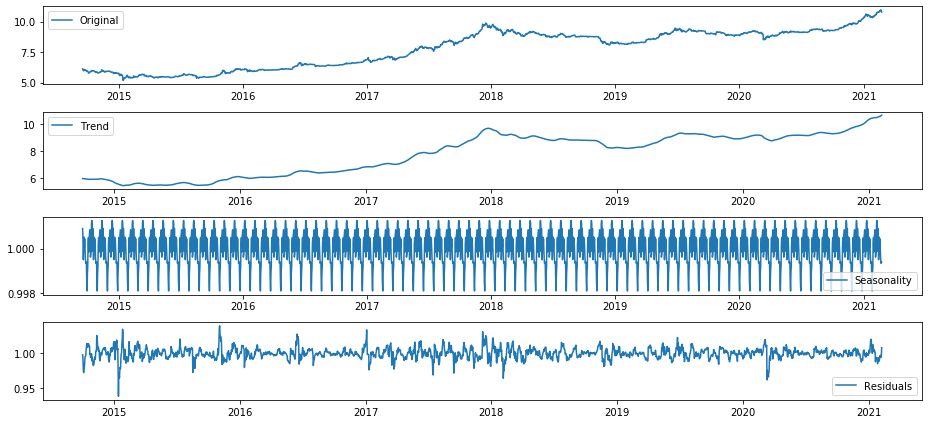

In [34]:
#로그변환 후  데이터
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 로그 변환을 통해 p-value가 1에서 0.97로 감소하였다.
- p-value 가 0.97 이므로 유의수준인 0.05보다 크다
- 따라서 귀무가설인 '비트코인의 시계열 데이터는 안정적이지 않다'는 기각 할 수 없다

#### 모델 설정
- ARIMA =  AR(Autoregressive) + I(Integrated) + MA(Moving Average)
- 자기회귀(AR Autoregressive)는 추세와 계절성을 제거한 잔차에 해당하는 부분을 모델링한다
- 이는 과거의 값이 일정한 균형 수준을 유지할 것이라고 예측하는 관점에 해당한다  

- MA(이동평균, Moving Average)는 추세에 해당하는 부분을 모델링 한다
- 모델의 예측보다 관측값이 더 높았을 경우, 다음 예측시에 예측치를 올려잡는 역할을 한다
- 최근 과거데이터의 증가와 감소 패턴이 지속될 것이라고 예측하는 관점에 해당한다

- I (차분누적, Integration)은 시계열 데이터에서 계절성에 해당하는 부분을 모델링 한다
- 위 3가지 모델을 모두 고려하여 적용하는 모델이 ARIMA모델이다


#### ARIMA 모델 사용시 적용할 모수 
- 자기회귀 모형(AR)의 시차를 의미하는 p
- 차분(diffdrence) 횟수를 의미하는 d
- 이동평균 모형(MA)의 시차를 의미하는 q
- 라고 할때

- p + q < 2
- p * q = 0
- 과 같은 값을 적용하는데
- 이는 자기회귀 모형의 시차나 이동평균 모형의 시차 중 하나의 값이 0이라는 설정이다.


#### ARIMA 모델 사용시 적용할 모수 구하기
- ARIMA의 적절한 모수 p,d,q를 선택하기 위한 방법 정론이 없다
- 모수 p,d,q는 
- ACF(Autocorrelation Function)
- PACF(Partial Autocorrelation Function)을 통해 결정할 수 있는데
- AutoCorrelation은 자기상관계수와 같은 것입니다.

- ACF 는 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수이다
- PACF 는 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수이다
- 즉,
- ACF를 통해 MA(이동평균) 모델의 시차 q를 결정하고
- PACF를 통해 AR(자기회귀) 모델의 시차 p를 결정한다

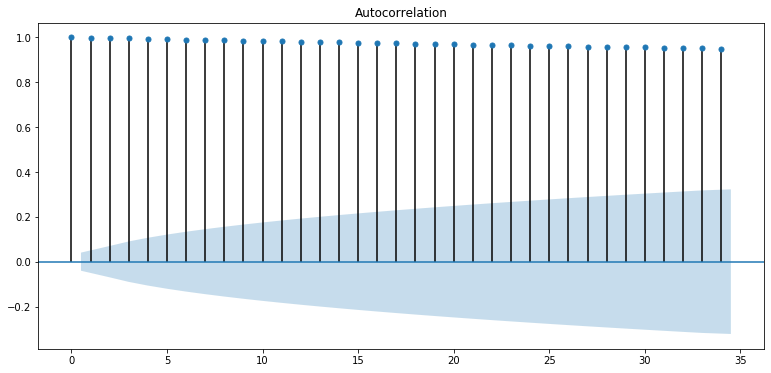

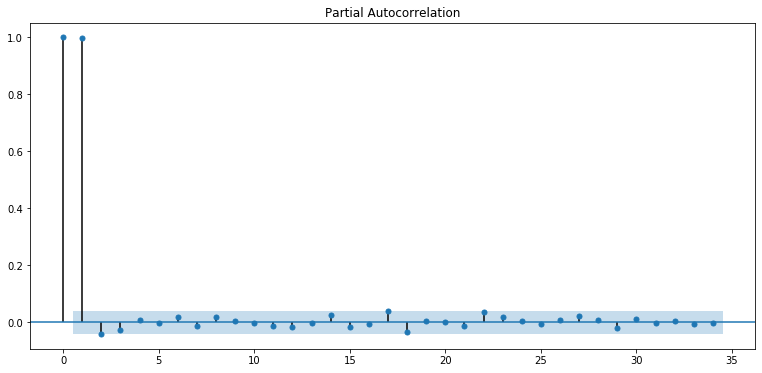

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF는 유의미한 변화량을 보이지 않으므로 , 이동편균의 시차인 q에 대해서 고려할필요가 없어 보인다. 따라서 이동평균의 시차 q=0 으로 설정하도록 한다
- PCFA 시각화를 보면 P 가 2 이상인 구간에는 PCFA가 거의 0에 가까우므로 p=1 이상적이라고 할 수 있다.


#### 적절한 차분 d 을 찾아서

Results of Dickey-Fuller Test:
Test Statistic                -1.457057e+01
p-value                        4.635789e-27
#Lags Used                     9.000000e+00
Number of Observations Used    2.341000e+03
Critical Value (1%)           -3.433146e+00
Critical Value (5%)           -2.862775e+00
Critical Value (10%)          -2.567428e+00
dtype: float64


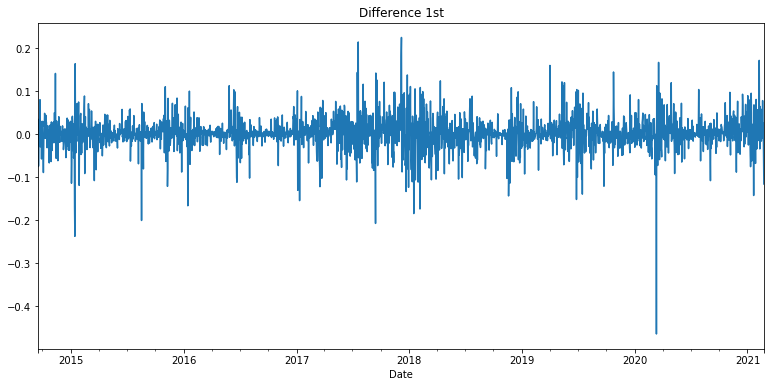

In [36]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.575306e+01
p-value                        1.216771e-28
#Lags Used                     2.500000e+01
Number of Observations Used    2.324000e+03
Critical Value (1%)           -3.433167e+00
Critical Value (5%)           -2.862784e+00
Critical Value (10%)          -2.567432e+00
dtype: float64


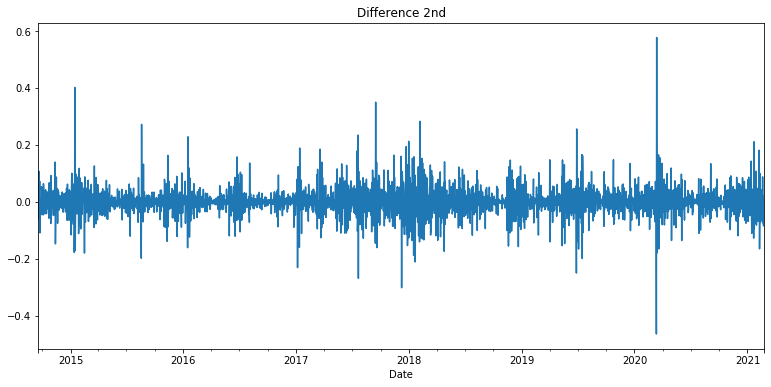

In [37]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                  -20.330553
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    2321.000000
Critical Value (1%)              -3.433171
Critical Value (5%)              -2.862786
Critical Value (10%)             -2.567433
dtype: float64


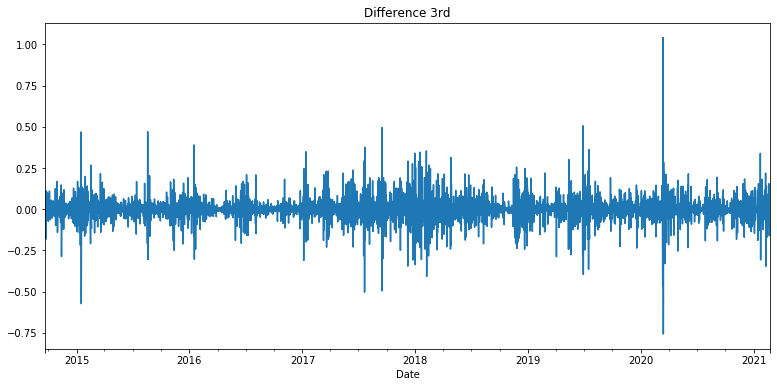

In [64]:
# 3차 차분 구하기
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

- 2차시 차분과 3차시 차분에서 유의미한 데이터 안정화가 이루어 졌으나, 3차시 차분에서 p-value가 0으로 나온것이 다소 의문스럽다.  
- ~차분 d는 2 혹은 3 로 설정하여 모델을 학습하기로 한다~
- 차분 d를 2 이상으로 설정할 수 없고, 2로 설정하여 모델 학습시 예측 그래프가 실제 데이터를 반영하지 못하는 결과를 나타내었으므로 1로 고정하여 모델을 학습하기로 하였다.



### STEP 4 : 학습, 테스트 데이터셋 생성

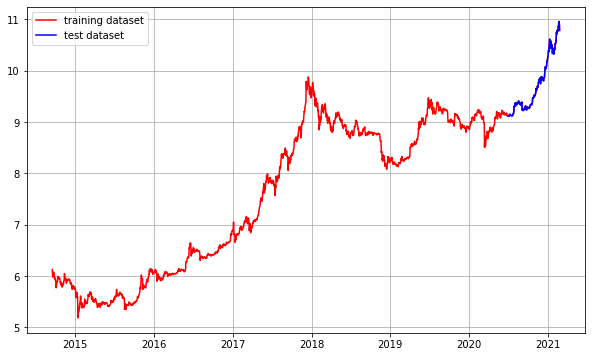

In [39]:
#학습데이터와 훈련데이터 분리
#분리 비율은 9:1로 설정 하였다
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend();

In [40]:
#학습데이터와 훈련데이터 분리
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2014-09-17    6.125414
2014-09-18    6.050771
Name: Close, dtype: float64
(2116,)
(236,)


### STEP 5 : 적정 ARIMA 모수를 적용한 모델 구축

In [70]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) #p,d,q -> p = 1 , d = 1 , q = 0
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3828.357
Method:                       css-mle   S.D. of innovations              0.040
Date:                Tue, 02 Mar 2021   AIC                          -7650.714
Time:                        22:40:30   BIC                          -7633.743
Sample:                    09-18-2014   HQIC                         -7644.500
                         - 07-02-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.672      0.094      -0.000       0.003
ar.L1.D.Close    -0.0169      0.022     -0.778      0.436      -0.060       0.026
                                    Root

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


### STEP 6 : ARIMA 모델 훈련과 테스트

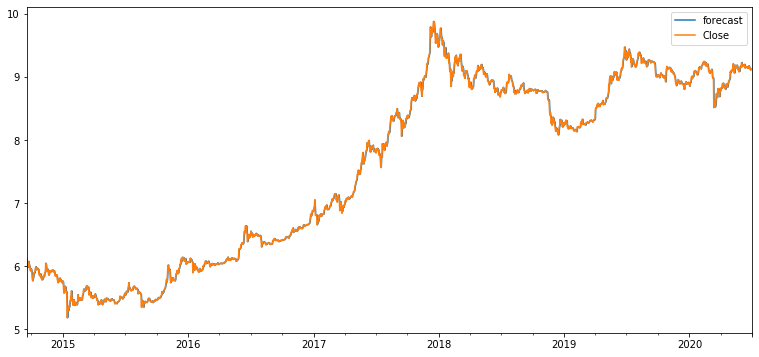

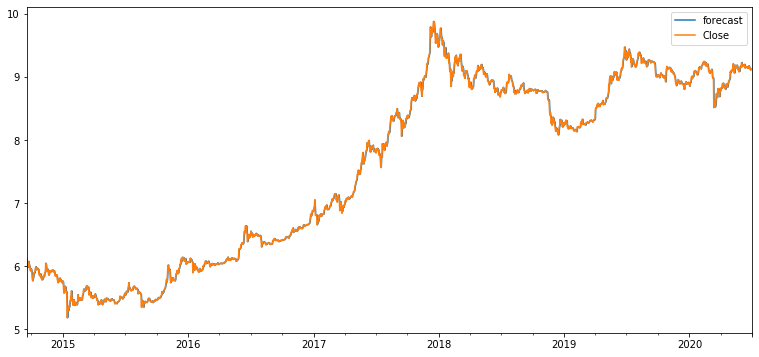

In [71]:
fitted_m.plot_predict()

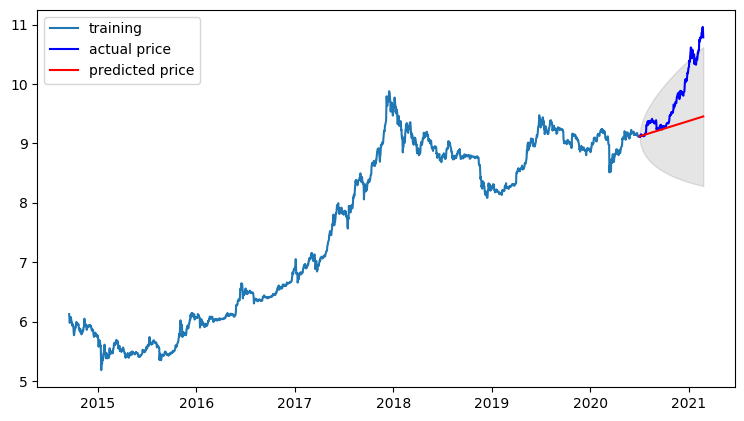

In [72]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [73]:
#로그 변환되었던 시계열을 다시 지수 변환하여 원본의 스케일로 평가지표를 계산하기
#np.exp() 함수를 이용하여 원본 스케일로 변환 하였다

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('평균제곱오차 MSE: ', mse) 

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('평균절대 오차 MAE: ', mae) 

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('평균제곱근오차 RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('평균절대비오차 MAPE: {:.2f}%'.format(mape*100))

평균제곱오차 MSE:  203780588.09252962
평균절대 오차 MAE:  8857.071259397107
평균제곱근오차 RMSE:  14275.173837559023
평균절대비오차 MAPE: 30.36%


#### 평가지표 MAPE
- 평균 절대 백분율 오차 ( MAPE )는 예측 방법의 예측 정확도 측정 값으로 , 기계의 회귀 문제에 대한 손실 함수 로도 사용됩니다. 학습 . 일반적으로 다음 공식으로 정의 된 비율로 정확도를 표현한다.(위키피디아)
#### 결론
- MAPE 값 기준으로 구현한 모델의 예측 정확도는 30% 오차율을 보인다.
- 오늘날 시시각각 쏟아지는 관련 기사에 주식시장 및 가상화폐 시장이 급등락을 하고 있다
- 때론 누군가의 말한마디, 정부정책의 발표, 개인투자자의 단합에 영향을 받는 시장의 모습을 보면,그 불완전성은 더욱 커질것이라고 생각한다.
- 앞으로 시장경제를 예측하기 위한 지표로 전통적인 경제 지표 뿐 아니라, 그동안 경제 지표에 반영되지 않았던 인터넷 커뮤니티의 키워드들을 숫자화 하여 이를 특성feature으로 반영한 모델들이 고려되어져야 할 것 같다.
- 또한 탈중앙화 경제,프로토콜 경제가 제도권에 안착하기 위해서는 실제 콘텐츠와의 연계로 해당 가상자산의 가치를 인정받고, 이와 더불어 투자자에 대한 보호정책, 국가디지털 통화와의 연계등을 더욱 고려해 보아야 할 것이다.

### 페이팔과 테슬라 주식 종목 가격 예측
- 비트코인 가격변동과의 상관관계 시각화 해보기
    - 최근 테슬라의 CEO이자 페이팔의 공동창업자인 일론머스크가 비트코인을 언급하고나서 비트코인의 가격이 급등하였다.
    - 페이팔이 비트코인을 결제통화로 지원한다는 공식발표가 있었고, 이에 비트코인의 가격이 상승하였다.
    - 이와 관련하여 세가지 시계열 데이터의 연관성이 있는지 알아보고자 한다

In [45]:

tsla_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
tsla = pd.read_csv(tsla_filepath, index_col='Date', parse_dates=True)
tsla_ts = tsla['Close']
tsla_ts


Date
2010-06-29      4.778000
2010-06-30      4.766000
2010-07-01      4.392000
2010-07-02      3.840000
2010-07-06      3.222000
                 ...    
2021-02-19    781.299988
2021-02-22    714.500000
2021-02-23    698.840027
2021-02-24    742.020020
2021-02-25    682.219971
Name: Close, Length: 2684, dtype: float64

In [46]:
pypl_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/PYPL.csv'
pypl = pd.read_csv(pypl_filepath, index_col='Date', parse_dates=True)
pypl_ts = pypl['Close']
pypl_ts

Date
2015-07-06     36.709999
2015-07-07     36.619999
2015-07-08     34.700001
2015-07-09     34.500000
2015-07-10     34.689999
                 ...    
2021-02-19    286.920013
2021-02-22    273.850006
2021-02-23    265.000000
2021-02-24    266.070007
2021-02-25    253.940002
Name: Close, Length: 1422, dtype: float64

In [47]:
tsla_ts.shape, pypl_ts.shape

((2684,), (1422,))

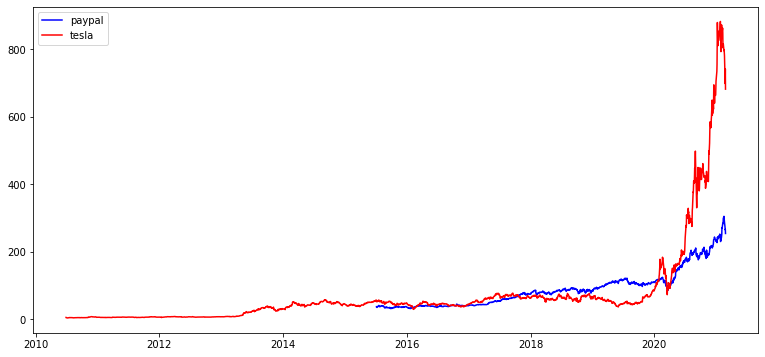

In [48]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.

#plt.plot(pypl_ts)
#plt.plot(tsla_ts)
plt.plot(pypl_ts,label='paypal',color='blue')
plt.plot(tsla_ts,label='tesla',color='red')
plt.legend(loc='upper left');

Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)


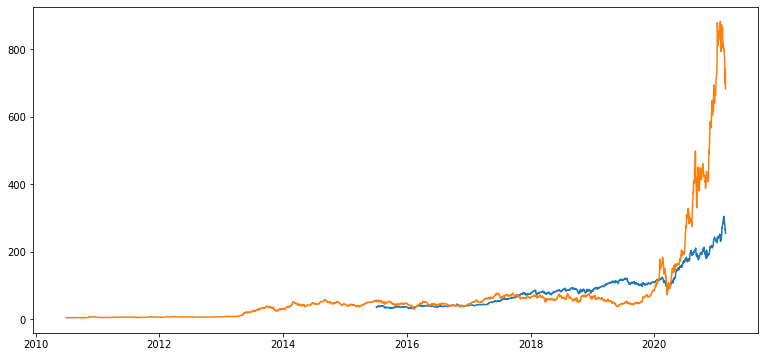

In [49]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
pypl_ts=pypl_ts.interpolate(method='time')
tsla_ts=tsla_ts.interpolate(method='time')
# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(pypl_ts[pypl_ts.isna()])
print(tsla_ts[tsla_ts.isna()])
# 다시 그래프를 확인해봅시다!
plt.plot(pypl_ts);
plt.plot(tsla_ts);

In [50]:
# 로그 변환을 통한 시계열 가공 
pypl_ts_log = np.log(pypl_ts)
pypl_ts_log.head()

Date
2015-07-06    3.603049
2015-07-07    3.600595
2015-07-08    3.546740
2015-07-09    3.540959
2015-07-10    3.546451
Name: Close, dtype: float64

In [51]:
augmented_dickey_fuller_test(pypl_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                    1.039873
p-value                           0.994669
#Lags Used                       10.000000
Number of Observations Used    1411.000000
Critical Value (1%)              -3.434993
Critical Value (5%)              -2.863591
Critical Value (10%)             -2.567862
dtype: float64


In [52]:
# 로그 변환을 통한 시계열 가공 
tsla_ts_log = np.log(tsla_ts)
tsla_ts_log.head()

Date
2010-06-29    1.564022
2010-06-30    1.561507
2010-07-01    1.479785
2010-07-02    1.345472
2010-07-06    1.170002
Name: Close, dtype: float64

In [53]:
tsla_ts_log.isna().sum()

0

In [54]:
pypl_ts_log.isna().sum()

0

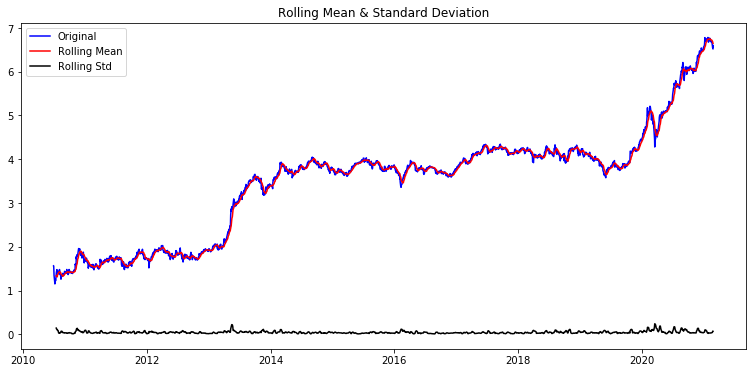

Results of Dickey-Fuller Test:
Test Statistic                    0.466576
p-value                           0.983821
#Lags Used                        0.000000
Number of Observations Used    2683.000000
Critical Value (1%)              -3.432790
Critical Value (5%)              -2.862618
Critical Value (10%)             -2.567344
dtype: float64


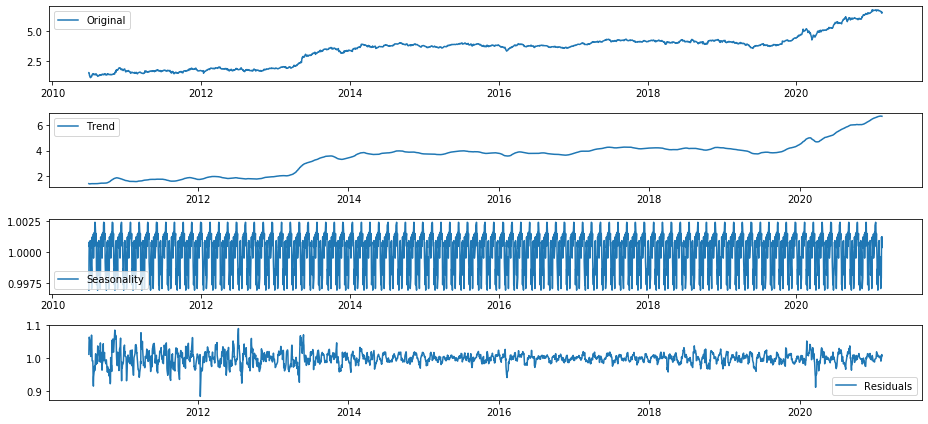

In [55]:
#테슬라 종목 분석
# 정성적 그래프 분석
plot_rolling_statistics(tsla_ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(tsla_ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(tsla_ts_log, model='multiplicative', period = 30) 

tsla_trend = decomposition.trend
tsla_seasonal = decomposition.seasonal
tsla_residual = decomposition.resid

plt.subplot(411)
plt.plot(tsla_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tsla_trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(tsla_seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(tsla_residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

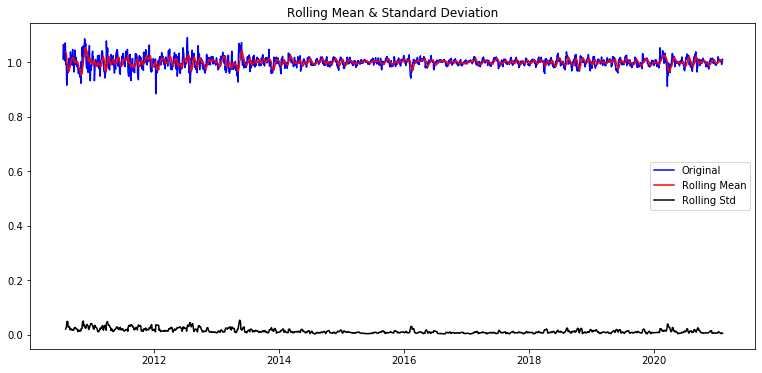

In [56]:
#테슬라 종목 잔차 구하기
#seasonal_decompose를 활용한 잔차 구하기
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(tsla_residual)

In [57]:
#추세와 계절성을 분리한 테슬라 시계열 데이터의  ADF test 
tsla_residual.dropna(inplace=True)
augmented_dickey_fuller_test(tsla_residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.260383e+01
p-value                        1.713052e-23
#Lags Used                     2.800000e+01
Number of Observations Used    2.625000e+03
Critical Value (1%)           -3.432844e+00
Critical Value (5%)           -2.862642e+00
Critical Value (10%)          -2.567356e+00
dtype: float64


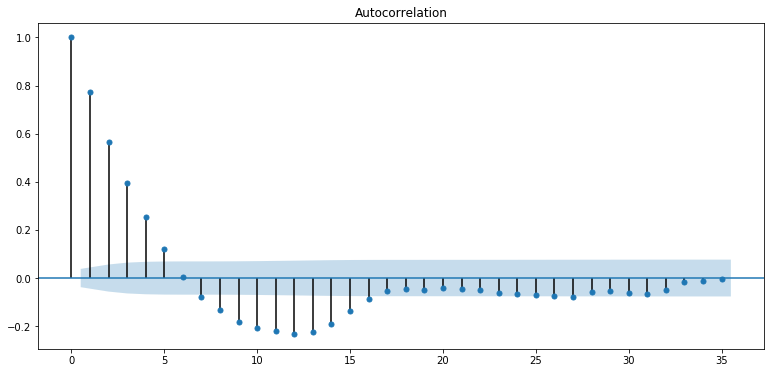

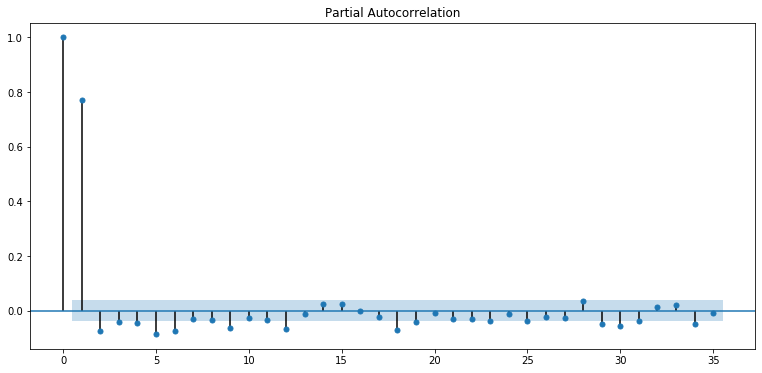

In [58]:
# 테슬라 종목의 ARIMA 모델 모수 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(tsla_residual)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(tsla_residual)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF는 6을 기준으로 전과 후의 변화량이 유의미해  보이므로, 이동평균의 시차 q=6 으로 설정하도록 한다
- PCFA 시각화를 보면 P 가 2 이상인 구간에는 PCFA가 거의 0에 가까우므로 p=1로 설정하는 것이 이상적이라고 할 수 있지만 
- p * q = 0 이어야 하므로 p=0 으로 설정한다.

Results of Dickey-Fuller Test:
Test Statistic                  -51.349215
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2682.000000
Critical Value (1%)              -3.432791
Critical Value (5%)              -2.862618
Critical Value (10%)             -2.567344
dtype: float64


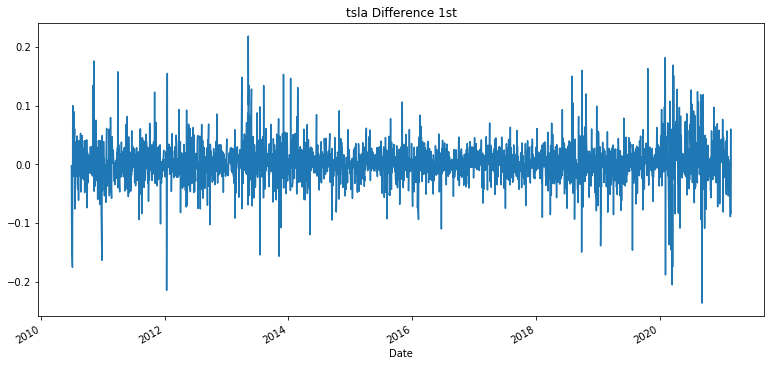

In [60]:
# 테슬라 1차 차분 구하기
tsla_diff_1 = tsla_ts_log.diff(periods=1).iloc[1:]
tsla_diff_1.plot(title='tsla Difference 1st')

augmented_dickey_fuller_test(tsla_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.652611e+01
p-value                        2.043412e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.654000e+03
Critical Value (1%)           -3.432816e+00
Critical Value (5%)           -2.862630e+00
Critical Value (10%)          -2.567350e+00
dtype: float64


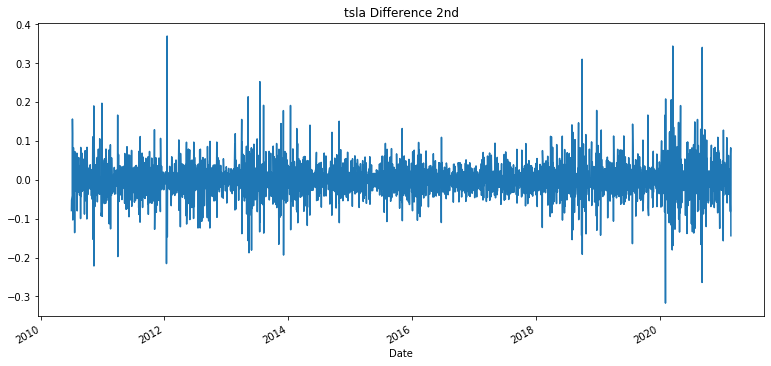

In [61]:
# 테슬라 2차 차분 구하기
tsla_diff_2 = tsla_diff_1.diff(periods=1).iloc[1:]
tsla_diff_2.plot(title='tsla Difference 2nd')

augmented_dickey_fuller_test(tsla_diff_2)

Results of Dickey-Fuller Test:
Test Statistic                  -21.326443
p-value                           0.000000
#Lags Used                       28.000000
Number of Observations Used    2652.000000
Critical Value (1%)              -3.432818
Critical Value (5%)              -2.862630
Critical Value (10%)             -2.567350
dtype: float64


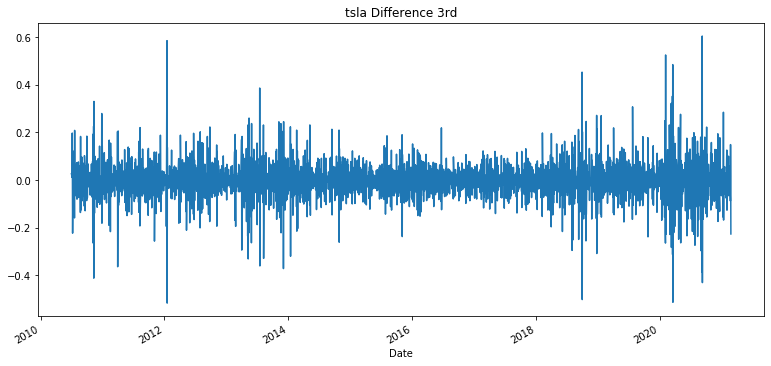

In [63]:
# 테슬라 3차 차분 구하기
tsla_diff_3 = tsla_diff_2.diff(periods=1).iloc[1:]
tsla_diff_3.plot(title='tsla Difference 3rd')

augmented_dickey_fuller_test(tsla_diff_3)

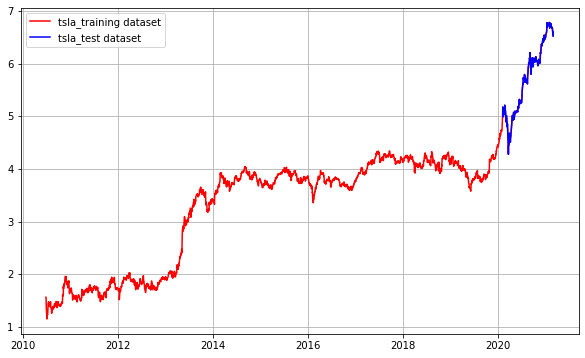

In [82]:
#학습데이터와 훈련데이터 분리
#분리 비율은 9:1로 설정 하였다
tsla_train_data, tsla_test_data = tsla_ts_log[:int(len(tsla_ts_log)*0.9)], tsla_ts_log[int(len(tsla_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(tsla_ts_log, c='r', label='tsla_training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(tsla_test_data, c='b', label='tsla_test dataset')
plt.legend();

In [83]:
#학습데이터와 훈련데이터 분리
print(tsla_ts_log[:2])
print(tsla_train_data.shape)
print(tsla_test_data.shape)

Date
2010-06-29    1.564022
2010-06-30    1.561507
Name: Close, dtype: float64
(2415,)
(269,)


In [94]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model_2 = ARIMA(tsla_train_data, order=(6, 1, 0)) #p,d,q -> p = 1 , d = 1 , q = 0
fitted_m_2 = model_2.fit(disp=-1)  
print(fitted_m_2.summary())

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2414
Model:                 ARIMA(6, 1, 0)   Log Likelihood                4861.402
Method:                       css-mle   S.D. of innovations              0.032
Date:                Tue, 02 Mar 2021   AIC                          -9706.805
Time:                        22:52:36   BIC                          -9660.492
Sample:                             1   HQIC                         -9689.961
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      2.192      0.028       0.000       0.003
ar.L1.D.Close     0.0097      0.020      0.477      0.633      -0.030       0.050
ar.L2.D.Close    -0.0224      0.020     

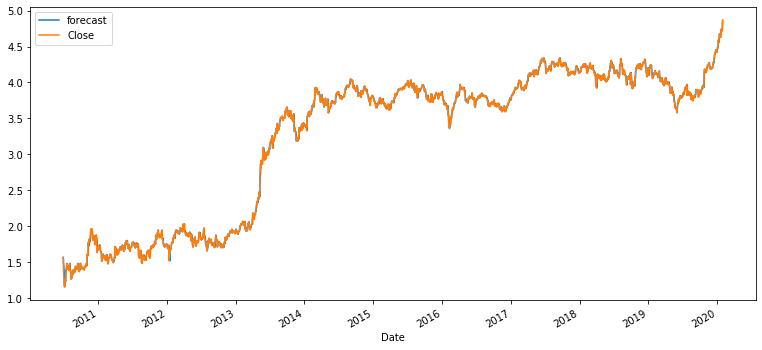

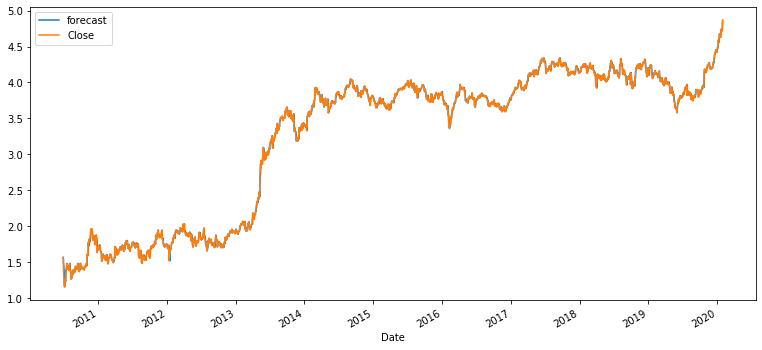

In [95]:
fitted_m_2.plot_predict()

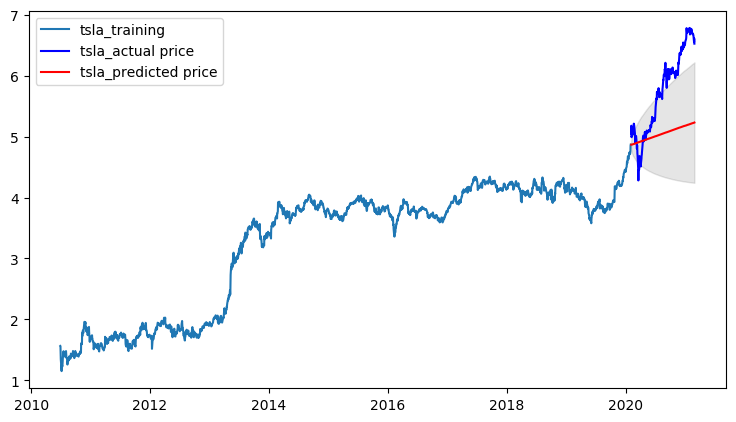

In [96]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m_2.forecast(len(tsla_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=tsla_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=tsla_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=tsla_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(tsla_train_data, label='tsla_training')
plt.plot(tsla_test_data, c='b', label='tsla_actual price')
plt.plot(fc_series, c='r',label='tsla_predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [97]:
#로그 변환되었던 시계열을 다시 지수 변환하여 원본의 스케일로 평가지표를 계산하기
#np.exp() 함수를 이용하여 원본 스케일로 변환 하였다

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(tsla_test_data), np.exp(fc))
print('평균제곱오차 MSE: ', mse) 

mae = mean_absolute_error(np.exp(tsla_test_data), np.exp(fc))
print('평균절대 오차 MAE: ', mae) 

rmse = math.sqrt(mean_squared_error(np.exp(tsla_test_data), np.exp(fc)))
print('평균제곱근오차 RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(tsla_test_data))/np.abs(np.exp(tsla_test_data)))
print('평균절대비오차 MAPE: {:.2f}%'.format(mape*100))

평균제곱오차 MSE:  96278.19607327138
평균절대 오차 MAE:  226.36432747743427
평균제곱근오차 RMSE:  310.2872799089118
평균절대비오차 MAPE: 46.90%


- 테슬라 종목에 대한 예측 결과는 46.9%의 오차를 지닌다.
- 시계열 데이터의 안정화가 덜 되었거나, airma 모델의 모수를 적절히 설정하지 못한것으로 보인다.
- 혹은 테슬라 종목의 2020년 이후 급격한 상승요인에는 과거 시계열데이터에서의 추세나 패턴의 상쇄로도 설명(예측) 불가능한 요인이 적용되었다고 해석할 수 도 있겠다.

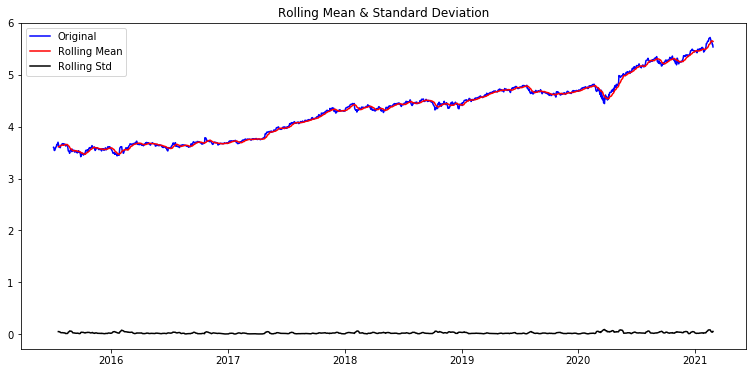

Results of Dickey-Fuller Test:
Test Statistic                    1.039873
p-value                           0.994669
#Lags Used                       10.000000
Number of Observations Used    1411.000000
Critical Value (1%)              -3.434993
Critical Value (5%)              -2.863591
Critical Value (10%)             -2.567862
dtype: float64


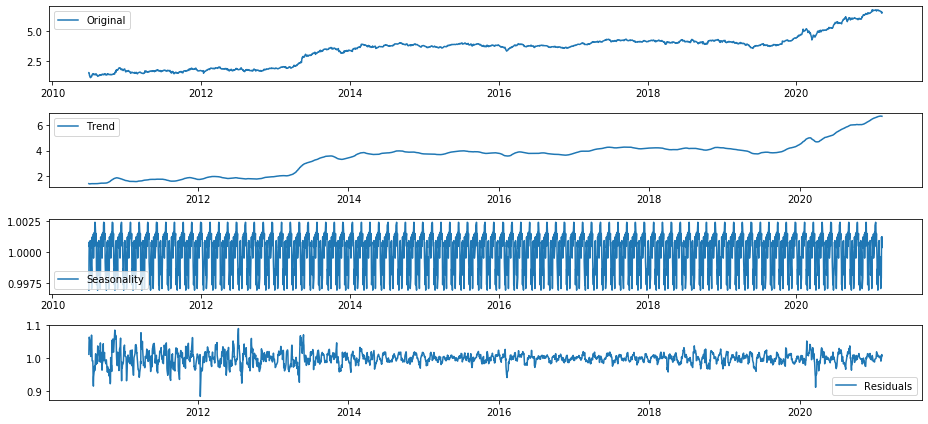

In [98]:
#페이팔 종목 분석
# 정성적 그래프 분석
plot_rolling_statistics(pypl_ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(pypl_ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pypl_ts_log, model='multiplicative', period = 30) 

pypl_trend = decomposition.trend
pypl_seasonal = decomposition.seasonal
pypl_residual = decomposition.resid

plt.subplot(411)
plt.plot(tsla_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tsla_trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(tsla_seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(tsla_residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

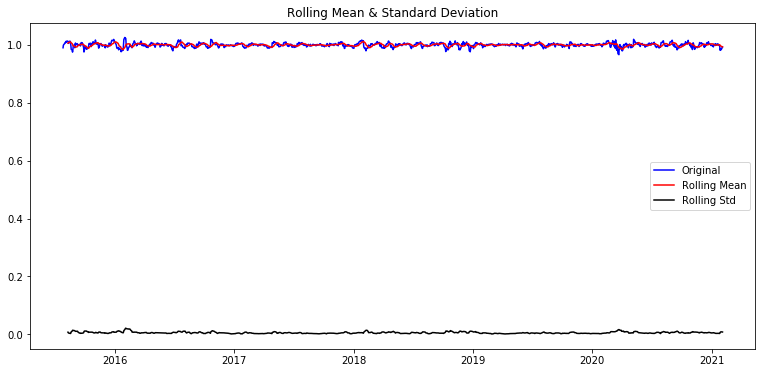

In [99]:
#페이팔 종목 잔차 구하기
#seasonal_decompose를 활용한 잔차 구하기
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(pypl_residual)

In [100]:
#추세와 계절성을 분리한 페이팔 시계열 데이터의  ADF test 
pypl_residual.dropna(inplace=True)
augmented_dickey_fuller_test(pypl_residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.339076e+01
p-value                        4.772824e-25
#Lags Used                     1.200000e+01
Number of Observations Used    1.379000e+03
Critical Value (1%)           -3.435101e+00
Critical Value (5%)           -2.863638e+00
Critical Value (10%)          -2.567887e+00
dtype: float64


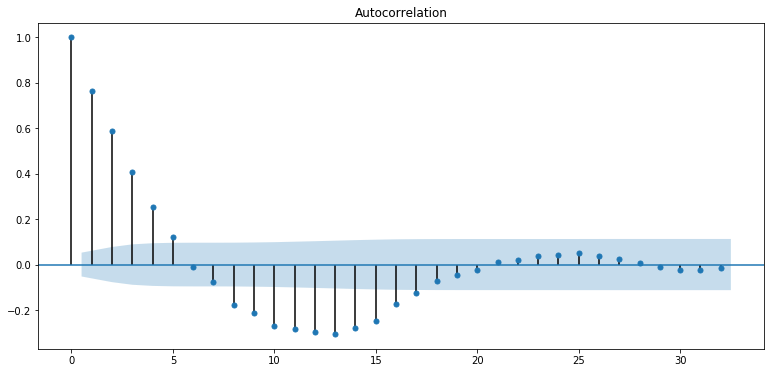

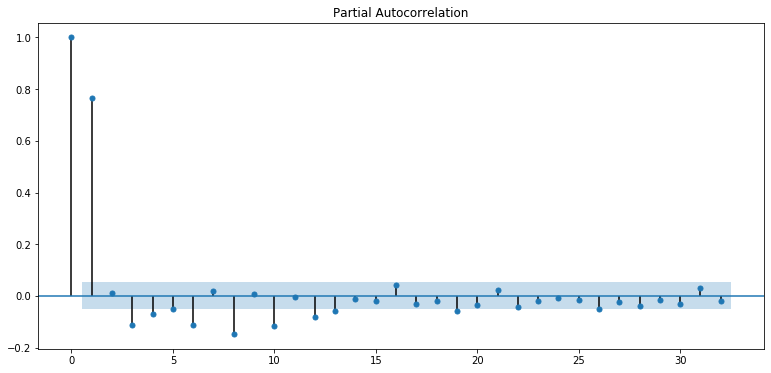

In [101]:
#페이팔 종목의 ARIMA 모델 모수 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(pypl_residual)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(pypl_residual)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 테슬라 종목과 유사한 ACF와 PACF 시각화를 볼 수 있다.
- ACF는 6을 기준으로 전과 후의 변화량이 유의미해  보이므로, 이동평균의 시차 q=6 으로 설정하도록 한다
- PCFA 시각화를 보면 P 가 2 이상인 구간에는 PCFA가 거의 0에 가까우므로 p=1로 설정하는 것이 이상적이라고 할 수 있지만 
- p * q = 0 이어야 하므로 p=0 으로 설정한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.303490e+01
p-value                        2.304078e-24
#Lags Used                     9.000000e+00
Number of Observations Used    1.411000e+03
Critical Value (1%)           -3.434993e+00
Critical Value (5%)           -2.863591e+00
Critical Value (10%)          -2.567862e+00
dtype: float64


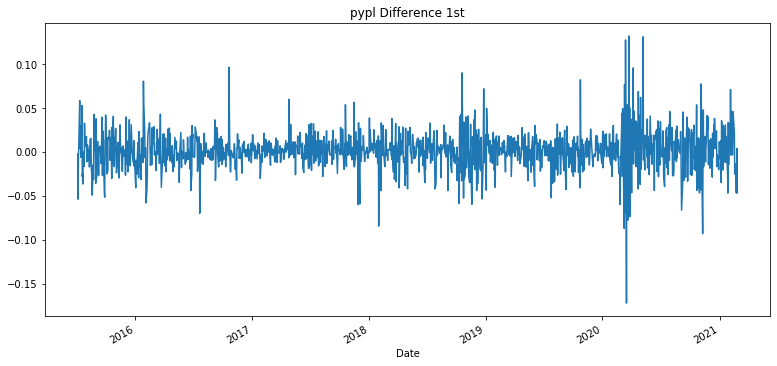

In [102]:
# 테슬라 1차 차분 구하기
pypl_diff_1 = pypl_ts_log.diff(periods=1).iloc[1:]
pypl_diff_1.plot(title='pypl Difference 1st')

augmented_dickey_fuller_test(pypl_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.364316e+01
p-value                        1.638464e-25
#Lags Used                     2.300000e+01
Number of Observations Used    1.396000e+03
Critical Value (1%)           -3.435043e+00
Critical Value (5%)           -2.863613e+00
Critical Value (10%)          -2.567873e+00
dtype: float64


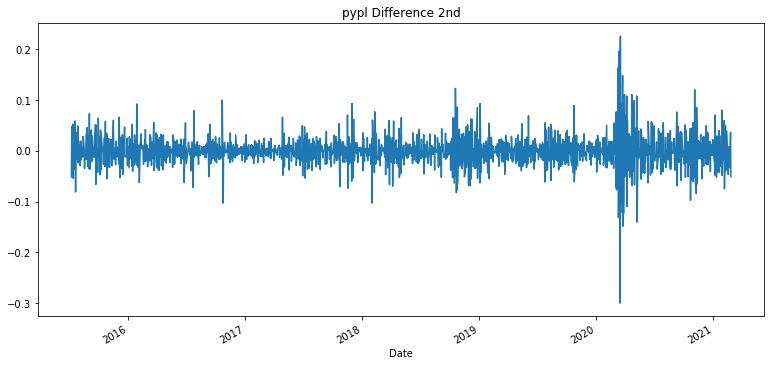

In [103]:
# 테슬라 2차 차분 구하기
pypl_diff_2 = pypl_diff_1.diff(periods=1).iloc[1:]
pypl_diff_2.plot(title='pypl Difference 2nd')

augmented_dickey_fuller_test(pypl_diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -1.675490e+01
p-value                        1.324639e-29
#Lags Used                     2.400000e+01
Number of Observations Used    1.394000e+03
Critical Value (1%)           -3.435050e+00
Critical Value (5%)           -2.863616e+00
Critical Value (10%)          -2.567875e+00
dtype: float64


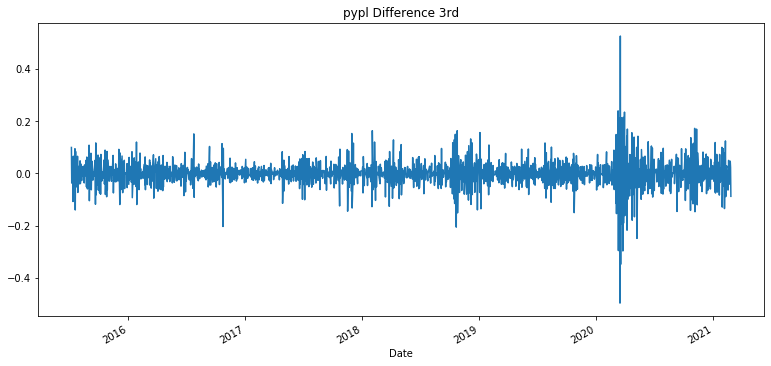

In [104]:
# 테슬라 3차 차분 구하기
pypl_diff_3 = pypl_diff_2.diff(periods=1).iloc[1:]
pypl_diff_3.plot(title='pypl Difference 3rd')

augmented_dickey_fuller_test(pypl_diff_3)

- 2차 차분과 3차 차분에서 유의미한 p-value의 감소가 보이지 않으므로 d=2 혹은 d=1로 설정한다

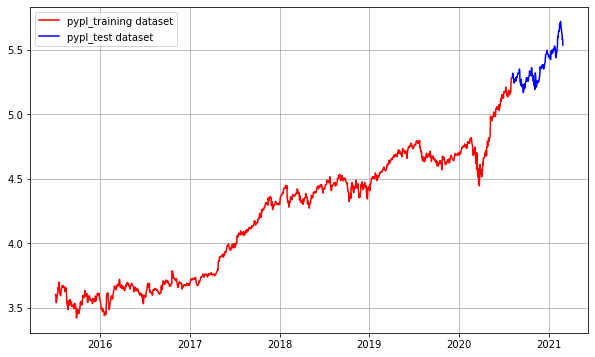

In [114]:
#학습데이터와 훈련데이터 분리
#분리 비율은 9:1로 설정 하였다
pypl_train_data, pypl_test_data = pypl_ts_log[:int(len(pypl_ts_log)*0.9)], pypl_ts_log[int(len(pypl_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(pypl_train_data, c='r', label='pypl_training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(pypl_test_data, c='b', label='pypl_test dataset')
plt.legend();

In [106]:
#학습데이터와 훈련데이터 분리
print(pypl_ts_log[:2])
print(pypl_train_data.shape)
print(pypl_test_data.shape)

Date
2015-07-06    3.603049
2015-07-07    3.600595
Name: Close, dtype: float64
(1279,)
(143,)


In [129]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model_3 = ARIMA(pypl_train_data, order=(6, 1, 0)) #p,d,q -> p = 1 , d = 1 , q = 0
fitted_m_3 = model_3.fit(disp=-1)  
print(fitted_m_3.summary())

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1278
Model:                 ARIMA(6, 1, 0)   Log Likelihood                3142.191
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 02 Mar 2021   AIC                          -6268.381
Time:                        23:21:18   BIC                          -6227.157
Sample:                             1   HQIC                         -6252.901
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.000      2.889      0.004       0.000       0.002
ar.L1.D.Close    -0.1281      0.028     -4.605      0.000      -0.183      -0.074
ar.L2.D.Close     0.0296      0.028     

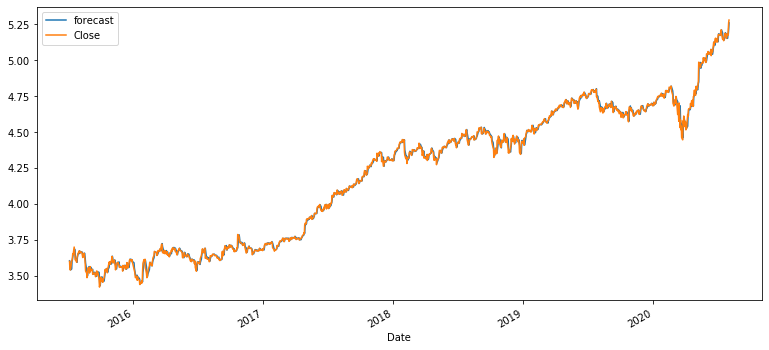

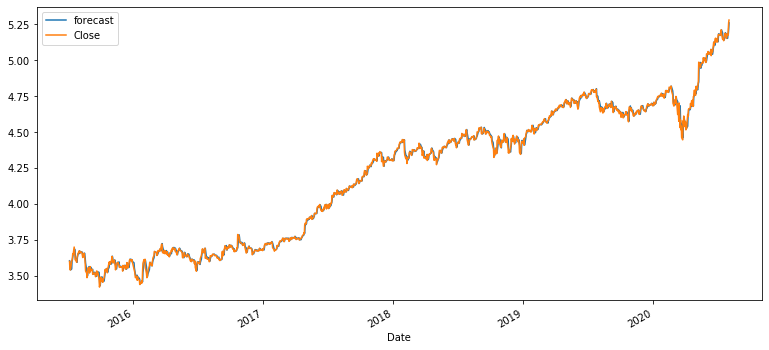

In [130]:
fitted_m_3.plot_predict()

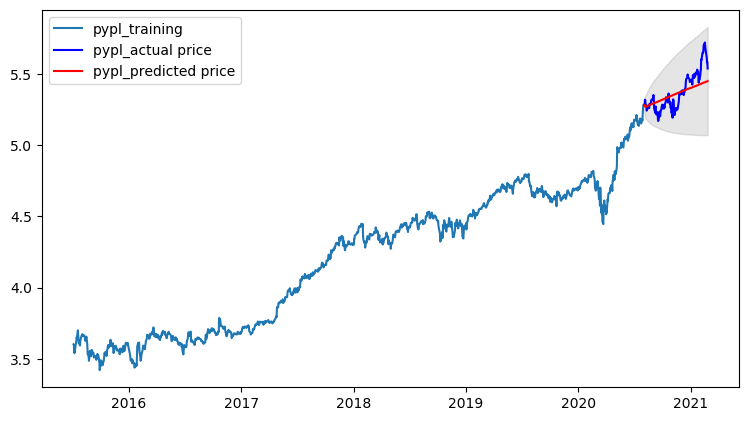

In [131]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m_3.forecast(len(pypl_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=pypl_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=pypl_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=pypl_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(pypl_train_data, label='pypl_training')
plt.plot(pypl_test_data, c='b', label='pypl_actual price')
plt.plot(fc_series, c='r',label='pypl_predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()



In [132]:
#로그 변환되었던 시계열을 다시 지수 변환하여 원본의 스케일로 평가지표를 계산하기
#np.exp() 함수를 이용하여 원본 스케일로 변환 하였다

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(pypl_test_data), np.exp(fc))
print('평균제곱오차 MSE: ', mse) 

mae = mean_absolute_error(np.exp(pypl_test_data), np.exp(fc))
print('평균절대 오차 MAE: ', mae) 

rmse = math.sqrt(mean_squared_error(np.exp(pypl_test_data), np.exp(fc)))
print('평균제곱근오차 RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(pypl_test_data))/np.abs(np.exp(pypl_test_data)))
print('평균절대비오차 MAPE: {:.2f}%'.format(mape*100))

평균제곱오차 MSE:  458.21224388667764
평균절대 오차 MAE:  15.490141130433681
평균제곱근오차 RMSE:  21.405892737437455
평균절대비오차 MAPE: 6.80%


- 페이팔에 대한 예측 결과는 6.80%의 오차를 지닌다.

ValueError: operands could not be broadcast together with shapes (143,) (269,) 

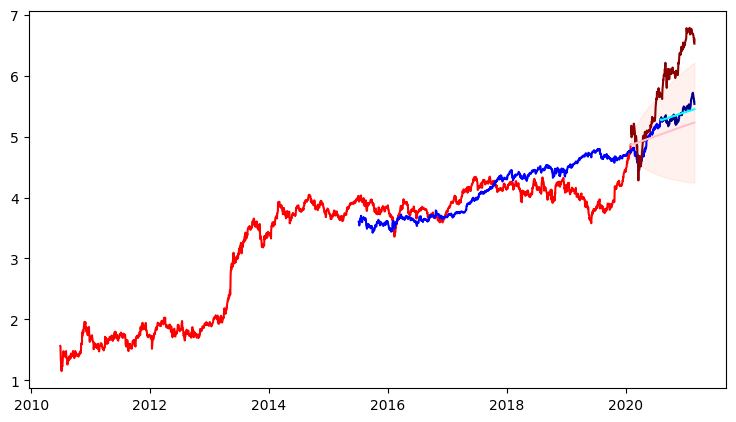

In [123]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m_2.forecast(len(tsla_test_data), alpha=0.05)  # 95% conf
fc2, se2, conf2 = fitted_m_3.forecast(len(pypl_test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=tsla_test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=tsla_test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=tsla_test_data.index)  # 예측결과의 상한 바운드

# Make as pandas series
fc_series2 = pd.Series(fc2, index=pypl_test_data.index)   # 예측결과
lower_series2 = pd.Series(conf2[:, 0], index=pypl_test_data.index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(conf2[:, 1], index=pypl_test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(tsla_train_data, c='red', label='tsla_training')
plt.plot(pypl_train_data, c='blue',label='pypl_training')
plt.plot(tsla_test_data, c='darkred', label='tsla_actual price')
plt.plot(pypl_test_data, c='darkblue', label='pypl_actual price')
plt.plot(fc_series, c='pink',label='tsla_predicted price')
plt.plot(fc_series2, c='cyan',label='pypl_predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='coral', alpha=.10)
plt.fill_between(lower_series2.index, lower_series2, upper_series, color='teal', alpha=.10)

plt.legend()
plt.show()



### 회고
- 아리마 모델의 모수를 구하는 방법에 이해가 아직 부족한 것 같다. 
- 추세와 계절성을 상쇄하고 잔차를 이용하여도 시계열 데이터를 안정화하는 작업이 쉽지 않았다.(정확하게는 p-value만으로 해당 데이터가 안정화 되었다고 판단하ㄴ다고 하였을때 앞서 살펴본 방법들을 적용하였음에도 p-value가 높아지는 현상을 이해하기 어려웠다.)
- ACF 와 PACF를 시각화 해보고 해당 시각화를 근거로 모델에 적용하려고 해도 모델에서 일정 크기 이상의 값을 모수로 설정 할 수 없었다
- d와 같은 경우 2보다 클 수 없었고, 2로 설정할 경우 시각화와 예측값 모두 지나치게 불안정해져서 원본 시계열 데이터와 크게 차이가 난 값을 반환하였다.
- 앞으로 라이프로그 데이터를 기반으로한 의료서비스나 예방의료에 대해서도 이번에 배운 시계열 데이터의 안정화를 적용할 수 있을지 시도해 보고 싶다.(의료 데이터는 사람의 건강과 밀접한 연관성을 띄는 민감한 시계열 데이터일때, 이를 로그변환이나 추세,계절성 상쇄와 같은 방법들을 적용하여 특정 질환의 발병 가능성을 놓치거나 지나치게 일반화 하게 되는것은 아닌지 더 알아봐야 할 문제일것 같다.)